In [1]:
# prompt: Help me import a dataset from Kaggle

!pip install kaggle # - installs kaggle
from google.colab import files # - import "files" method
from google.colab import drive
drive.mount('/content/drive') # - mounts google drive

Mounted at /content/drive


In [2]:
files.upload() # - use "files" method to read a kaggle.json key

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"felbraga97","key":"ae907c0fb033794e492284f0365a5af0"}'}

In [3]:
!mkdir -p ~/.kaggle # - creates directory kaggle at root
!cp kaggle.json ~/.kaggle/ # - copy the key to kaggle directory
!chmod 600 ~/.kaggle/kaggle.json # - protects the file to a owner read-only stance

In [4]:
%cd /content/drive/MyDrive/DeepGlobe
!pwd

/content/drive/MyDrive/DeepGlobe
/content/drive/MyDrive/DeepGlobe


In [5]:
!kaggle datasets download -d balraj98/deepglobe-road-extraction-dataset # - downloads a dataset
!unzip deepglobe-road-extraction-dataset.zip # - unzips dataset

Streaming output truncated to the last 5000 lines.
  inflating: train/723199_sat.jpg    
  inflating: train/723226_mask.png   
  inflating: train/723226_sat.jpg    
  inflating: train/723436_mask.png   
  inflating: train/723436_sat.jpg    
  inflating: train/723483_mask.png   
  inflating: train/723483_sat.jpg    
  inflating: train/723622_mask.png   
  inflating: train/723622_sat.jpg    
  inflating: train/723722_mask.png   
  inflating: train/723722_sat.jpg    
  inflating: train/723970_mask.png   
  inflating: train/723970_sat.jpg    
  inflating: train/723990_mask.png   
  inflating: train/723990_sat.jpg    
  inflating: train/724095_mask.png   
  inflating: train/724095_sat.jpg    
  inflating: train/724431_mask.png   
  inflating: train/724431_sat.jpg    
  inflating: train/724485_mask.png   
  inflating: train/724485_sat.jpg    
  inflating: train/724705_mask.png   
  inflating: train/724705_sat.jpg    
  inflating: train/724870_mask.png   
  inflating: train/724870_sat.jpg    

In [6]:
import os # - imports operational system method
import sys # - imports sys method
import numpy as np # - imports numpy
import re # - imports re
import cv2 # - imports open cv
import matplotlib.pyplot as plt # - imports matplotlib
import tensorflow as tf # - imports tensorflow

In [7]:
# defining function for dataLoading function
framObjTrain = {'img' : [],
           'mask' : []
          }

def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 128): # - shape is fixed at 128.128
    imgNames = os.listdir(imgPath) # - takes the name of every file in imgPath
    maskNames = []

    ## generating mask names
    for mem in imgNames:
        mem = mem.split('_')[0]
        if mem not in maskNames:
            maskNames.append(mem) # - appends every file name from imgPath to maskNames

    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'

    for i in range (len(imgNames)):
        try:
            img = plt.imread(imgAddr + maskNames[i] + '_sat.jpg')
            mask = plt.imread(maskAddr + maskNames[i] + '_mask.png')

            # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # - converts images to grayscale

        except:
            continue

        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        frameObj['img'].append(img)
        frameObj['mask'].append(mask[:,:,0]) # this is because its a binary mask and img is present in channel 0

    return frameObj

In [8]:
# defining Conv2d block for our u-net
# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)

    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x =tf.keras.layers.Activation('relu')(x)

    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)

    return x



# Now defining Unet
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm) # - first convolutional layer
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1) # - first pooling layer
    p1 = tf.keras.layers.Dropout(droupouts)(p1)

    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm) # - second conv; duplicates filters
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)

    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)

    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)

    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)

    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)

    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)

    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)

    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)

    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

In [9]:
## instanctiating model
inputs = tf.keras.layers.Input((128, 128, 3)) # - size, size, number of color channels
unet = GiveMeUnet(inputs, droupouts= 0.07)
unet.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(unet, to_file='UnetArchitecture.png', show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

In [14]:
framObjTrain = LoadData( framObjTrain, imgPath = '/content/drive/MyDrive/DeepGlobe/train',
                        maskPath = '/content/drive/MyDrive/DeepGlobe/train'
                         , shape = 128)

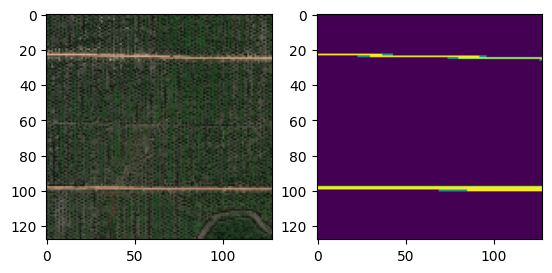

In [15]:
## displaying data loaded by our function
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.show()

In [16]:
retVal = unet.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 20, verbose = 1)
# does something that takes a while. original had 40 epochs.

Epoch 1/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 89s 127ms/step - accuracy: 0.9196 - loss: 0.2907
Epoch 2/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - accuracy: 0.9538 - loss: 0.1377
Epoch 3/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.9553 - loss: 0.1202
Epoch 4/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 32s 81ms/step - accuracy: 0.9578 - loss: 0.1090
Epoch 5/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.9592 - loss: 0.1033
Epoch 6/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.9606 - loss: 0.0991
Epoch 7/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 32s 81ms/step - accuracy: 0.9616 - loss: 0.0950
Epoch 8/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 32s 81ms/step - accuracy: 0.9637 - loss: 0.0885
Epoch 9/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.9642 - loss: 0.0868
Epoch 10/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.9652 - loss: 0.0836
Epoch 11/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.9661 - loss: 0.0811
Epoch 12/20
390/390 ━━━━━━━━━

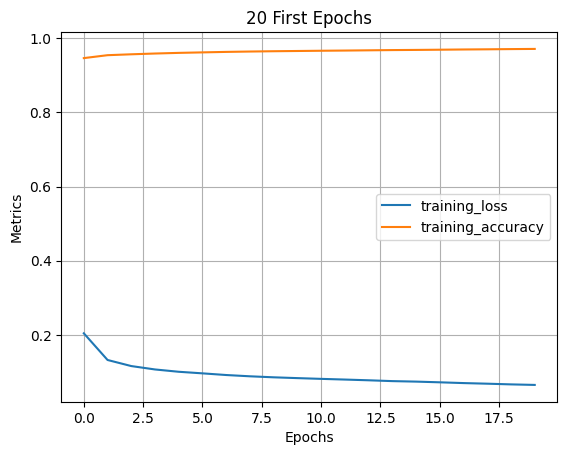

In [39]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend() # - plots a chart describing training loss and training accuracy over epochs
plt.grid(True)
plt.title('20 First Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.show()

In [19]:
def selectnPredict (valMap, model, shape = 128):
    ## getting and proccessing val data
    img = valMap['img'][0:20]
    mask = valMap['mask'][0:20]
    #mask = mask[0:16]

    imgProc = img [0:10]
    imgProc = np.array(img)

    predictions = model.predict(imgProc)


    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Aerial image')

    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Routes')

    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual Routes')

In [20]:
imgPred, actuals, masks = selectnPredict(framObjTrain, unet)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [21]:
# from random import randint
# imgIndex = randint(1, 21)

In [37]:
for imgIndex in range(20):
    Plotter(actuals[imgIndex], imgPred[imgIndex][:,:,0], masks[imgIndex])
    plt.savefig(f'/content/drive/MyDrive/DeepGlobe/plots/img{imgIndex}_20ep_plot.png')


Output hidden; open in https://colab.research.google.com to view.

In [29]:
!pwd
# !mkdir /checkpoints/

/content/drive/MyDrive/DeepGlobe


In [31]:
unet.save('/content/drive/MyDrive/DeepGlobe/checkpoints/MapSegmentationGenerator20ep.h5')
unet.save('/content/drive/MyDrive/DeepGlobe/checkpoints/MapSegGen20ep.keras')

In [38]:
retVal_2 = unet.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 20, verbose = 1)
# 20 more epochs

Epoch 1/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 32s 83ms/step - accuracy: 0.9709 - loss: 0.0645
Epoch 2/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 84ms/step - accuracy: 0.9716 - loss: 0.0626
Epoch 3/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 40s 82ms/step - accuracy: 0.9713 - loss: 0.0633
Epoch 4/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.9721 - loss: 0.0605
Epoch 5/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 42s 84ms/step - accuracy: 0.9714 - loss: 0.0628
Epoch 6/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 84ms/step - accuracy: 0.9728 - loss: 0.0591
Epoch 7/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9735 - loss: 0.0565
Epoch 8/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - accuracy: 0.9733 - loss: 0.0568
Epoch 9/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 42s 84ms/step - accuracy: 0.9736 - loss: 0.0560
Epoch 10/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 40s 82ms/step - accuracy: 0.9741 - loss: 0.0547
Epoch 11/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - accuracy: 0.9746 - loss: 0.0533
Epoch 12/20
390/390 ━━━━━━━━━━

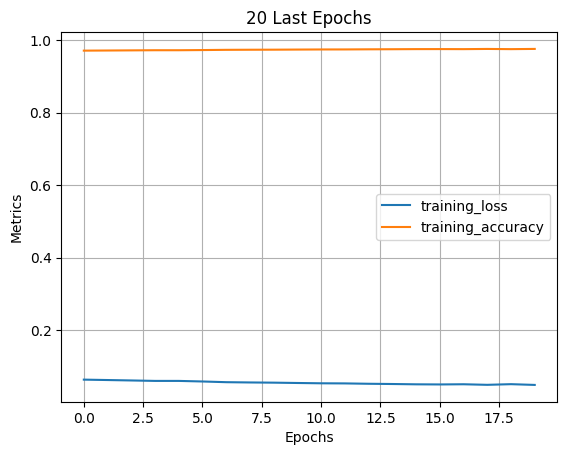

In [40]:
plt.plot(retVal_2.history['loss'], label = 'training_loss')
plt.plot(retVal_2.history['accuracy'], label = 'training_accuracy')
plt.legend() # - plots a chart describing training loss and training accuracy over epochs
plt.grid(True)
plt.title('20 Last Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.show()

In [41]:
total_loss = retVal.history['loss'] + retVal_2.history['loss'] # - concatenates both moments loss
total_accuracy = retVal.history['accuracy'] + retVal_2.history['accuracy'] # - concatenates both moments accuracy

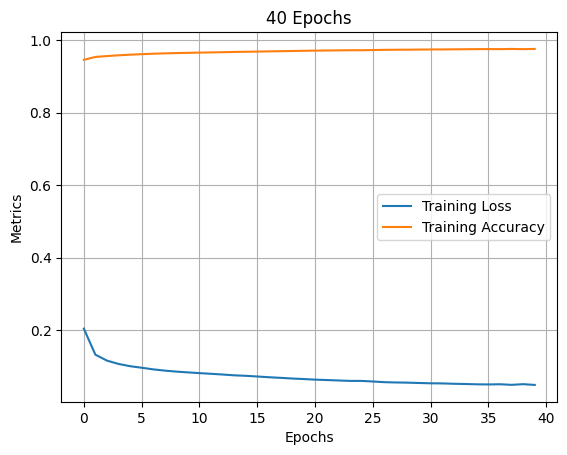

In [42]:
plt.plot(total_loss, label='Training Loss')
plt.plot(total_accuracy, label='Training Accuracy')
plt.grid(True)
plt.legend()
plt.title('40 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.show()

In [43]:
imgPred, actuals, masks = selectnPredict(framObjTrain, unet)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [45]:
for imgIndex in range(20):
    Plotter(actuals[imgIndex], imgPred[imgIndex][:,:,0], masks[imgIndex])
    plt.savefig(f'/content/drive/MyDrive/DeepGlobe/plots/img{imgIndex}_40ep_plot.png')

Output hidden; open in https://colab.research.google.com to view.

In [46]:
unet.save('/content/drive/MyDrive/DeepGlobe/checkpoints/MapSegmentationGenerator40ep.h5')
unet.save('/content/drive/MyDrive/DeepGlobe/checkpoints/MapSegGen40ep.keras')